In [1]:
# this clones the PGM repository in the ./PGM folder if it does not exists
# please modify this line as needed if you want to have the PMG repository elsewhere
import os, sys
pgm_path = './PGM/'
if not os.path.isdir(pgm_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append('./PGM/source/')
sys.path.append('./PGM/utilities/')
sys.path.append('./DNA_utils/')

In [9]:
# imports
from common_imports import set_num_threads
set_num_threads(2) # Set the number of cores. Must be executed before importing numpy&numba.
import rbm, RBM_utils, utilities
import DNA_utils, DNA_sequence_logo, DNA_plots_utils

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse

%matplotlib inline

In [3]:
# load pre-trained RBM and pre-compute the partition functions
path = './trained_RBMs/'
file_name = 'RBM_DC6.data'
RBM_dc6 = RBM_utils.loadRBM(path + file_name)
RBM_dc6.AIS(n_betas=40000,verbose=0)

file_name = 'RBM_DC8.data'
RBM_dc8 = RBM_utils.loadRBM(path + file_name)
RBM_dc8.AIS(n_betas=40000,verbose=0)

file_name = 'RBM_SC8.data'
RBM_sc = RBM_utils.loadRBM(path + file_name)
RBM_sc.AIS(n_betas=40000,verbose=0)

Mismatch dimensions (1000, 80), [10, 80], reinitializating I
Mismatch dimensions (1000, 20, 4), [10, 20, 4], reinitializating I


(104.3171, 0.035993958956208334)

In [4]:
# load full datasets (must be in the ./data folder)
path = './data/'
filename = 's100_5th.fasta'
all_data_5, counts_5 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)

filename = 's100_6th.fasta'
all_data_6, counts_6 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)

filename = 's100_7th.fasta'
all_data_7, counts_7 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)

filename = 's100_8th.fasta'
all_data_8, counts_8 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)

In [5]:
# split left and right loops, keeping counts - I will not keep here "global" counts, that I will introduce later as weights
# in each plot, average etc...
# left loops
seqs_5_l_2num = all_data_5[:, :20]
seqs_6_l_2num = all_data_6[:, :20]
seqs_7_l_2num = all_data_7[:, :20]
seqs_8_l_2num = all_data_8[:, :20]

# right loops
seqs_5_r_2num = all_data_5[:, 20:]
seqs_6_r_2num = all_data_6[:, 20:]
seqs_7_r_2num = all_data_7[:, 20:]
seqs_8_r_2num = all_data_8[:, 20:]

In [ ]:
# prepare data for plotting

In [6]:
# compute likelihoods of left-right seqs (for panel A)
points_5 = np.array([RBM_sc.likelihood(seqs_5_l_2num), RBM_sc.likelihood(seqs_5_r_2num)]).T
points_6 = np.array([RBM_sc.likelihood(seqs_6_l_2num), RBM_sc.likelihood(seqs_6_r_2num)]).T
points_7 = np.array([RBM_sc.likelihood(seqs_7_l_2num), RBM_sc.likelihood(seqs_7_r_2num)]).T
points_8 = np.array([RBM_sc.likelihood(seqs_8_l_2num), RBM_sc.likelihood(seqs_8_r_2num)]).T

In [7]:
# compute likelihoods of full seqs at round 5, with RBM-D8 and prepare data to be plotted in panel B
liks_5_D8 = RBM_dc8.likelihood(all_data_5)
l5_lr = points_5[:,0] + points_5[:,1]
points_5_panelB = np.stack((l5_lr, liks_5_D8), axis=-1)

In [10]:
# compute likelihoods of full seqs, and obtain peak sequences (for panel C)
liks_5_f = RBM_dc6.likelihood(all_data_5)
liks_6_f = RBM_dc6.likelihood(all_data_6)
liks_7_f = RBM_dc6.likelihood(all_data_7)
liks_8_f = RBM_dc6.likelihood(all_data_8)
avs = [np.average(liks_5_f, weights=counts_5), np.average(liks_6_f, weights=counts_6),
       np.average(liks_7_f, weights=counts_7), np.average(liks_8_f, weights=counts_8)]

my_bins = []
nbins = 29
begin = min(liks_5_f)
end = max(liks_8_f)
bin_len = (end - begin) / nbins
p = begin
while p<=end:
    p += bin_len
    my_bins.append(p)

fig, axes = plt.subplots()
h5_counts_dens, h5_bins_dens, h5_bars_dens = axes.hist(liks_5_f, weights=counts_5, bins=my_bins, density=True)
plt.close() # do not show figure
h5_x = [(h5_bins_dens[i+1] + h5_bins_dens[i])/2 for i in range(len(h5_bins_dens)-1)]
h5_y = h5_counts_dens.copy()
def single_gauss(x, m1, x1, s1):
    return (m1 * np.exp(-(x-x1)**2/(2 * s1)) / np.sqrt(2 * np.pi * s1))
def multi_gauss(x, m1, m2, m3, x1, x2, x3, s1, s2, s3):
    return (m1 * np.exp(-(x-x1)**2/(2 * s1)) / np.sqrt(2 * np.pi * s1) + m2 * np.exp(-(x-x2)**2/(2 * s2)) / np.sqrt(2 * np.pi * s2) + m3 * np.exp(-(x-x3)**2/(2 * s3)) / np.sqrt(2 * np.pi * s3))
popt5, pcov5 = curve_fit(multi_gauss, h5_x, h5_y, 
                         p0 = [0.1, 0.1, 0.1, -57, -42, -28, 10, 10, 10], 
                         bounds=([0,0,0,-65,-50,-35,0.01,0.01,0.01], [1,1,1,-55,-35,-20,100,100,100]))

t_pars1 = popt5[[0,3,6]]
t_pars2 = popt5[[1,4,7]]
t_pars3 = popt5[[2,5,8]]
peak1 = (t_pars1[1] - np.sqrt(t_pars1[2]), t_pars1[1] + np.sqrt(t_pars1[2]))
peak2 = (t_pars2[1] - np.sqrt(t_pars2[2]), t_pars2[1] + np.sqrt(t_pars2[2]))
peak3 = (t_pars3[1] - np.sqrt(t_pars3[2]), t_pars3[1] + np.sqrt(t_pars3[2]))
seq_peak1 = []
seq_peak2 = []
seq_peak3 = []
for i, ll in enumerate(liks_5_f):
    if ll > peak1[0] and ll < peak1[1]:
        seq_peak1.append(list(all_data_5[i]))
    if ll > peak2[0] and ll < peak2[1]: 
        seq_peak2.append(list(all_data_5[i]))
    if ll > peak3[0] and ll < peak3[1]:
        seq_peak3.append(list(all_data_5[i]))

seq_peak1 = np.array(seq_peak1)
seq_peak2 = np.array(seq_peak2)
seq_peak3 = np.array(seq_peak3)

seq_peak1.shape, seq_peak2.shape, seq_peak3.shape

((209159, 40), (333203, 40), (74417, 40))

In [11]:
# part 2 for panel C: compute liks of peak seqs
# split peak seqs
seq_peak1_l = seq_peak1[:, :20]
seq_peak1_r = seq_peak1[:, 20:]

seq_peak2_l = seq_peak2[:, :20]
seq_peak2_r = seq_peak2[:, 20:]

seq_peak3_l = seq_peak3[:, :20]
seq_peak3_r = seq_peak3[:, 20:]

# compute loglik
x_peak1 = RBM_sc.likelihood(seq_peak1_l)
y_peak1 = RBM_sc.likelihood(seq_peak1_r)

x_peak2 = RBM_sc.likelihood(seq_peak2_l)
y_peak2 = RBM_sc.likelihood(seq_peak2_r)

x_peak3 = RBM_sc.likelihood(seq_peak3_l)
y_peak3 = RBM_sc.likelihood(seq_peak3_r)

# prepare some random seqs
np.random.seed(0)
rand_data_l = np.random.randint(low=0, high=3, size=(100000, 20), dtype=np.int16)
rand_data_r = np.random.randint(low=0, high=3, size=(100000, 20), dtype=np.int16)

x_rand = RBM_sc.likelihood(rand_data_l)
y_rand = RBM_sc.likelihood(rand_data_r)

Text(0.02, 0.91, 'd')

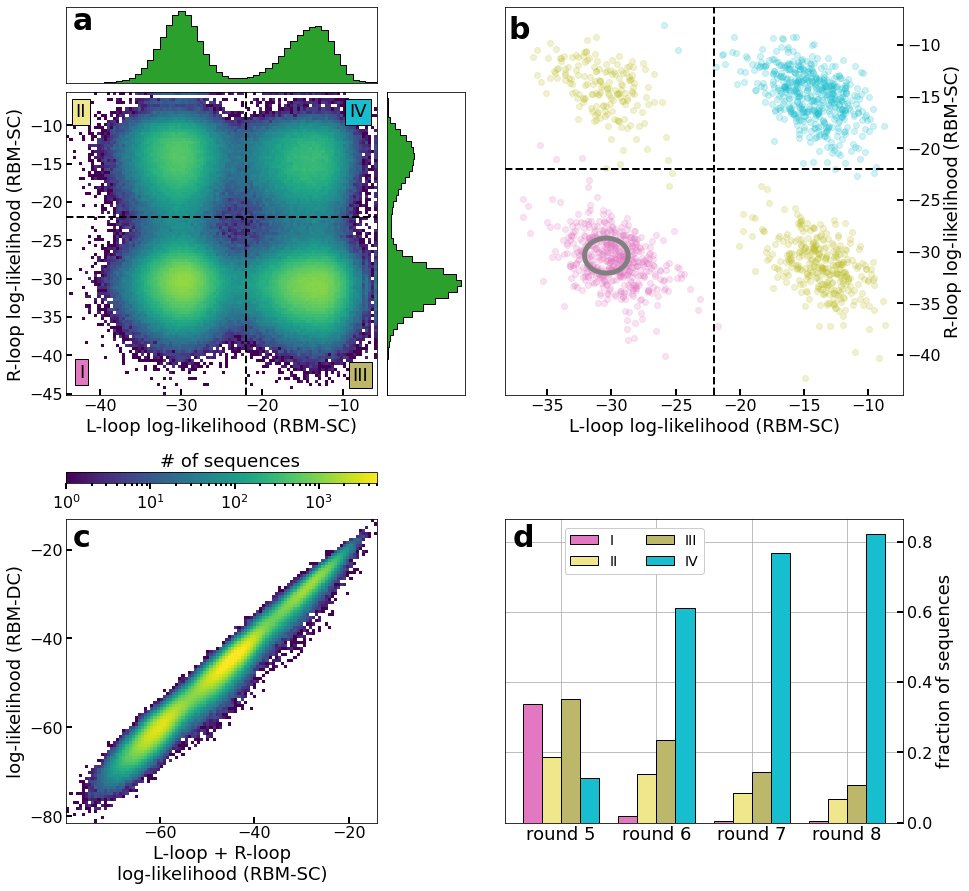

In [12]:
# make figure
fig = plt.figure(figsize=(15, 15))
wr = [1, 1]
hr = [1, 1]
gs = fig.add_gridspec(ncols=2, nrows=2, hspace=0.1, wspace=0.1, width_ratios=wr, height_ratios=hr)
linpos = -22
####################################################################################################
####################################################################################################
# panel A
wrA = [0.8, 0.2]
hrA = [0.2, 0.8]
gsA = gs[0,0].subgridspec(ncols=2, nrows=2, hspace=0.05, wspace=0.05, width_ratios=wrA, height_ratios=hrA)
ax11 = fig.add_subplot(gsA[1,0])
hist = ax11.hist2d(points_5[:, 0], points_5[:, 1], weights=counts_5, bins=100, cmap='viridis',
                   norm=mcolors.LogNorm(vmin=1, vmax=5000))
#ax11.set_title('round 5', fontsize=18)
ax11.axvline([linpos], color='k', linestyle='dashed', linewidth=2)
ax11.axhline([linpos], color='k', linestyle='dashed', linewidth=2)
ax11.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax11.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax11.tick_params(axis='both', labelsize=16)
ax11.set_ylabel('R-loop log-likelihood (RBM-SC)', fontsize=18) #RBM-S8
ax11.set_xlabel('L-loop log-likelihood (RBM-SC)', fontsize=18) #RBM-S8


t = plt.text(0.04, 0.06, 'I', transform=ax11.transAxes, fontsize=18)
t.set_bbox(dict(facecolor='tab:pink', alpha=1, edgecolor='black'))
t = plt.text(0.03, 0.92, 'II', transform=ax11.transAxes, fontsize=18)
t.set_bbox(dict(facecolor='khaki', alpha=1, edgecolor='black'))
t = plt.text(0.92, 0.05, 'III', transform=ax11.transAxes, fontsize=18)
t.set_bbox(dict(facecolor='darkkhaki', alpha=1, edgecolor='black'))
t = plt.text(0.91, 0.92, 'IV', transform=ax11.transAxes, fontsize=18)
t.set_bbox(dict(facecolor='tab:cyan', alpha=1, edgecolor='black'))

####################################################################################################
# histo up
ax11_up = fig.add_subplot(gsA[0,0], sharex=ax11)
ax11_up.hist(points_5[:, 0], weights=counts_5, bins=50, color="C2")
ax11_up.hist(points_5[:, 0], weights=counts_5, bins=50, histtype='step', color="k")
#ax11_up.set_xticks([])
#ax11_up.set_yticks([])
ax11_up.tick_params(axis='both', colors='None')

ax11_up.text(0.02, 0.7, 'a', fontsize=30, color='k', weight='bold', transform=ax11_up.transAxes)
####################################################################################################
# histo right
ax11_rt = fig.add_subplot(gsA[1,1], sharey=ax11)
ax11_rt.hist(points_5[:, 1], bins=50, color="C2", orientation='horizontal')
ax11_rt.hist(points_5[:, 1], bins=50, histtype='step', color="k", orientation='horizontal')
#ax11_rt.set_xticks([])
#ax11_rt.set_yticks([])
ax11_rt.tick_params(axis='both', colors='None')

####################################################################################################
####################################################################################################
# panel B
n_max = 500 # max number of plotted seqs for each peak
ax2 = fig.add_subplot(gs[0,1])
ax2.scatter(x_peak1[:n_max], y_peak1[:n_max], color="tab:pink", alpha=0.2)
ax2.scatter(x_peak2[:n_max], y_peak2[:n_max], color="tab:olive", alpha=0.2)
ax2.scatter(x_peak3[:n_max], y_peak3[:n_max], color="tab:cyan", alpha=0.2)

ellipse = Ellipse((np.mean(x_rand), np.mean(y_rand)), 
                  width=2*np.std(x_rand), height=2*np.std(y_rand),
                  edgecolor="gray", lw=5, facecolor="None")
ax2.add_artist(ellipse)
ax2.axvline([linpos], color='k', linestyle='dashed', linewidth=2)
ax2.axhline([linpos], color='k', linestyle='dashed', linewidth=2)
ax2.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax2.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax2.tick_params(axis='both', labelsize=16)
ax2.set_xlabel('L-loop log-likelihood (RBM-SC)', fontsize=18) #RBM-S8
ax2.set_ylabel('R-loop log-likelihood (RBM-SC)', fontsize=18) #RBM-S8
ax2.text(0.01, 0.92, 'b', fontsize=30, color='k', weight='bold', transform=ax2.transAxes)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
####################################################################################################
####################################################################################################
# subgridspec for the panel c (to add the colorbar, keeping panel C a square)
hrB = [0.2, 0.8]
wrB = [0.8, 0.2]
gs_C = gs[1, 0].subgridspec(ncols=2, nrows=2, hspace=0.05, wspace=0.05, width_ratios=wrB, height_ratios=hrB)

####################################################################################################
hr = [0.3, 0.1, 0.2]
gs_cb = gs_C[0,0].subgridspec(ncols=1, nrows=3, wspace=0.2, height_ratios=hr)
cb_ax1 = fig.add_subplot(gs_cb[1,0])
fig.colorbar(hist[3], cax=cb_ax1, orientation='horizontal')
cb_ax1.tick_params(axis='both', direction='out', length=6, width=2, colors='k')
cb_ax1.tick_params(which='minor', direction='out', length=3, width=2, colors='k')
cb_ax1.tick_params(axis='both', labelsize=16)
cb_ax1.text(0.3, 1.5, '# of sequences', fontsize=18, transform=cb_ax1.transAxes)

####################################################################################################
ax3 = fig.add_subplot(gs_C[1,0])
ax3.hist2d(points_5_panelB[:, 0], points_5_panelB[:, 1], bins=100, cmap='viridis', 
           norm=mcolors.LogNorm(vmin=1, vmax=5000))
ax3.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax3.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax3.tick_params(axis='both', labelsize=16)
ax3.set_xlabel('L-loop + R-loop\nlog-likelihood (RBM-SC)', fontsize=18) #RBM-S8
ax3.set_ylabel('log-likelihood (RBM-DC)', fontsize=18) #RBM-D8
ax3.set_yticks([-20, -40, -60, -80])
ax3.text(0.02, 0.91, 'c', fontsize=30, color='k', weight='bold', transform=ax3.transAxes)
#ax3.yaxis.tick_right()
#ax3.yaxis.set_label_position("right")

####################################################################################################
####################################################################################################
hrD = [0.2, 0.8]
gs_D = gs[1, 1].subgridspec(ncols=1, nrows=2, hspace=0.05, wspace=0.05, height_ratios=hrD)

ax4 = fig.add_subplot(gs_D[1,0])
x = np.arange(4)
width = 0.2
allpoints = [points_5, points_6, points_7, points_8]
# frac in area I for each round
frac_I = [np.sum((p[:,0]<linpos) & (p[:,1]<linpos)) / p.shape[0] for p in allpoints]
# frac in area I for each round
frac_II = [np.sum((p[:,0]<linpos) & (p[:,1]>linpos)) / p.shape[0] for p in allpoints]
# frac in area I for each round
frac_III = [np.sum((p[:,0]>linpos) & (p[:,1]<linpos)) / p.shape[0] for p in allpoints]
# frac in area I for each round
frac_IV = [np.sum((p[:,0]>linpos) & (p[:,1]>linpos)) / p.shape[0] for p in allpoints]

ax4.bar(x - 3*width/2, frac_I, width, label='I', edgecolor = 'k', color = 'tab:pink', zorder=2)
ax4.bar(x - width/2, frac_II, width, label='II', edgecolor = 'k', color = 'khaki', zorder=2)
ax4.bar(x + width/2, frac_III, width, label='III', edgecolor = 'k', color = 'darkkhaki', zorder=2)
ax4.bar(x + 3*width/2, frac_IV, width, label='IV', edgecolor = 'k', color = 'tab:cyan', zorder=2)

ax4.legend(fontsize=14, ncol=2, loc=(0.15, 0.82), framealpha=1)

ax4.set_ylabel('fraction of sequences', fontsize=18)
ax4.set_xticks([0,1,2,3])
ax4.set_xticklabels(["round 5", "round 6", "round 7", "round 8"])
ax4.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax4.tick_params(axis='x', labelsize=18)
ax4.tick_params(axis='y', labelsize=16)
ax4.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.grid(zorder=-1)
ax4.text(0.02, 0.91, 'd', fontsize=30, color='k', weight='bold', transform=ax4.transAxes)
#################################################################################################################